## Importing Packages Needed

In [1]:
import numpy as np
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline

## Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [3]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [4]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected,bound):
    """
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
    """
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Chi Squared functions

In [5]:
"""
    Compute the data's chi squared values.

    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float/list
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
"""
def chsq(observed_values, expected_values, err):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

Error Finding Functions

In [6]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [7]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [8]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

Finding Peak of Fittings Function

In [9]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)
    
    return minima, maxima, minima_e, maxima_e

In [10]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params, freq_low, freq_high, noise, data = 'parkes', freq=0):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    """
    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break 
    """

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if data=='parkes':
            for n,p in enumerate(peakpos):
                if p>670 and p<710:
                    component1 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
                elif p>720:
                    component2 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
        elif data!='parkes' and len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)
        
    """
    if len(peakpos)==2 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
    elif len(peakpos)==3 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[2], intensity=peakint[2])
        error = np.array(err)*(deg_mod)        
    elif len(peakpos)==4 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[3], intensity=peakint[3])
        error = np.array(err)*(deg_mod)   
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   """
   
    #Converts the frequency from bins to MHz    
    if data=='parkes':
        freq=(((freq_high-freq_low)/nofreqband)*(freqband))+freq_low+((freq_high-freq_low)/(nofreqband*2))
    else:
        freq=freq[freqband]

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [11]:
def fit_peaks(fit, freqband, pcov, params, noise, frequency):
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    peakpos = params[1]
    paramint = params[0]
    errcov = np.sqrt(np.diag(pcov))
    err = errcov[1]
    if len(params)>3:
        peakpos=np.append(peakpos,params[4])
        paramint=np.append(paramint,params[3])
        err = np.append(err,errcov[4])
    if len(params)>6:
        peakpos=np.append(peakpos,params[7])
        paramint=np.append(paramint,params[6])
        err=np.append(err,errcov[7])

    print(peakpos)
    peakint = multi_gauss(peakpos, *params)
    print(peakint)

    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(paramint)
        paramint = list(paramint)
        rm = paramint.index(mn)   
        print(rm)
        peakpos=np.delete(peakpos,rm)
        peakint=np.delete(peakint,rm)
        err=np.delete(err,rm)

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)

    #Converts the frequency from bins to MHz    
    freq=frequency[freqband]
    
    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [12]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

Removing outliers

In [13]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<20:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [14]:
"""
    Plotting functions to plot the gaussian fit, three gaussian fit with the gaussians filled in,
    and the peaks of the gaussian fit. 
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    gfit1 = gauss(x, *params1)
    params2 = params[3:6]
    gfit2 = gauss(x, *params2)
    if len(params)>6:
        params3 = params[6:9]
        gfit3 = gauss(x, *params3)
    if len(params)>9:
        params4 = params[9:12]
        gfit4 = gauss(x, *params4)
    
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    if len(params)>6:
        py.plot(x, gfit3, "r")
        py.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
    if len(params)>9:
        py.plot(x, gfit4, "b")
        py.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [15]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return ((m * np.array(x)) + c)

In [16]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

#### Parkes Data Set

In [17]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [18]:
averageprofiles = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/Parkes_archive_files/B1944-2600s-T-f32-pazi.pdv', dtype=fulldatatype)
maxf=4000
minf=700
no_freq_bands = max(averageprofiles['frequency']) + 1
size_freq = (maxf-minf) / no_freq_bands
halfsize_freq = size_freq / 2

#### EPN Profiles

In [19]:
bkk = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-129.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-168.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2['frequency']=1
bkk=np.append(bkk,bkk2)
bkk_phase = max(bkk['phase']) + 1
bkk_freq = [129.4,168.4]

In [20]:
ant = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-400-gb-ant94.txt', dtype=fulldatatype)
ant2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-800-gb-ant94.txt', dtype=fulldatatype)
ant3 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1330-gb-ant94.txt', dtype=fulldatatype)
ant4 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1640-gb-ant94.txt', dtype=fulldatatype)
ant2['frequency']=1
ant3['frequency']=2
ant4['frequency']=3
ant=np.append(ant,ant2)
ant=np.append(ant,ant3)
ant=np.append(ant,ant4)
ant_phase = max(ant['phase']) + 1
ant_freq = [400,800,1330,1640]

In [21]:
gl = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-410-Lovell-gl98.txt', dtype=fulldatatype)
gl2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-610-Lovell-gl98.txt', dtype=fulldatatype)
gl3 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-925-Lovell-gl98.txt', dtype=fulldatatype)
gl4 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1408-Lovell-gl98.txt', dtype=fulldatatype)
gl2['frequency']=1
gl3['frequency']=2
gl4['frequency']=3
gl=np.append(gl,gl2)
gl=np.append(gl,gl3)
gl=np.append(gl,gl4)
gl_phase = max(gl['phase']) + 1
gl_freq = [410,610,925,1408]

In [22]:
j = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-673.9-Parkes-j98.txt', dtype=fulldatatype)
j_phase = max(j['phase']) + 1
j_freq = [673.9]

In [23]:
wc =np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1418-Arecibo-wc.txt', dtype=fulldatatype)
wc_phase = max(wc['phase']) + 1
wc_freq = [1418]

In [24]:
sgg = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1420-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-4750-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2['frequency']=1
sgg=np.append(sgg,sgg2)
sgg_phase = max(sgg['phase']) + 1
sgg_freq = [1420,4750]

In [25]:
hkk = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-4850-Effelsberg-hkk.txt', dtype=fulldatatype)
hkk_phase = max(hkk['phase']) + 1
hkk_freq = [4850]

# INDIVIDUAL FREQUENCY BAND

Following Section is for error checking. It displays how each frequency band is fitted and it's peaks. 

#### Parkes Data Set

In [26]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 28

f = averageprofiles['frequency'] == freqband
x=averageprofiles['phase'][f]
y=averageprofiles['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,635,0,0,675,0,0,712,0,0,720,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,770,np.inf])
#expected2=(0.1,660,6,0.75,690,20,0.2,710,10,0.25,740,15)

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error)

#py.axis([200,400,-0.05,0.07])

<ipython-input-8-872f30e54463>:32: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


(600.0, 825.0, -0.1, 2.8)

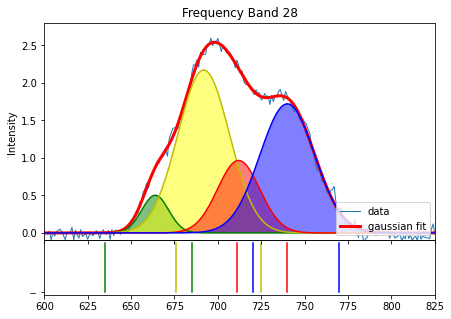

In [27]:
#Plot fill parameters
params1 = params[0:3]
params2 = params[3:6]
params3 = params[6:9]
params4 = params[9:12]
gfit1 = gauss(x, *params1)
gfit2 = gauss(x, *params2)
gfit3 = gauss(x, *params3)
gfit4 = gauss(x, *params4)
#Boundary parameters
yt=[0,1]
x1=[635,635]
x2=[685,685]
x3=[676,676]
x4=[725,725]
x5=[711,711]
x6=[740,740]
x7=[720,720]
x8=[770,770]

    
plot = py.figure(figsize=(7, 5))
grid = py.GridSpec(5, 1, hspace=0, wspace=0)
boundary = plot.add_subplot(grid[4, 0])
main_ax = plot.add_subplot(grid[0:4, 0], sharex=boundary)


main_ax.plot(x, y, lw=1, label='data')
main_ax.plot(x,fit,color='red',lw=3,label='gaussian fit')
main_ax.plot(x, gfit1, "g")
main_ax.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
main_ax.plot(x, gfit2, "y")
main_ax.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
main_ax.plot(x, gfit3, "r")
main_ax.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
main_ax.plot(x, gfit4, "b")
main_ax.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
boundary.plot(x1,yt, "g", '--')
boundary.plot(x2,yt, "g", '--')
boundary.plot(x3,yt, "y", '--')
boundary.plot(x4,yt, "y", '--')
boundary.plot(x5,yt, "r", '--')
boundary.plot(x6,yt, "r", '--')
boundary.plot(x7,yt, "b", '--')
boundary.plot(x8,yt, "b", '--')

py.title("Frequency Band 28")

py.ylabel('Intensity')
py.xlabel('Frequency (Bins)')
main_ax.legend(loc='lower right')
boundary.label_outer()
main_ax.label_outer()
py.axis([600,825,-0.1,2.8])

(210.9375, 298.828125, -0.1, 2.8)

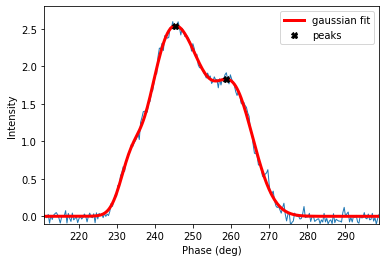

In [28]:
plot_peaks(x*(360/1024),y,profile_comp)
py.axis([210.9375,298.828125,-0.1,2.8])

#### EPN Profiles

In [29]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = j['frequency'] == freqband
x=j['phase'][f]
y=j['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(1,55,3,0.5,60,3)
bounds1=([0,0,0,0,0,0],[np.inf,j_phase,np.inf,np.inf,j_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
j_comp = fit_peaks(fit, freqband, cov, params,error,j_freq)
j_components = [j_comp]

[56.02017022 60.86188052]
[0.9860197  0.51831046]


In [30]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = wc['frequency'] == freqband
x=wc['phase'][f]
y=wc['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.1,470,10,0.6,505,3,0.4,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
wc_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',wc_freq)
wc_components = [wc_comp]

In [31]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(40,225,10,100,400,5,60,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg1_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)

<ipython-input-8-872f30e54463>:32: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-10-9957581a523b>:55: RuntimeWarning: divide by zero encountered in double_scalars
  if(max(peakint)/noise)>3:


In [32]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 1

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(100,170,5,100,270,3)
bounds1=([0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg2_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)
sgg_components = [sgg1_comp,sgg2_comp]

In [33]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = hkk['frequency'] == freqband
x=hkk['phase'][f]
y=hkk['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.8,87,5,0.8,100,3)
bounds1=([0,0,0,0,0,0],[np.inf,hkk_phase,np.inf,np.inf,hkk_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
hkk_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',hkk_freq)
hkk_components = [hkk_comp]

[ 0.81358543 89.0201764   4.21280163  0.73601453 98.95715694  2.57399603]


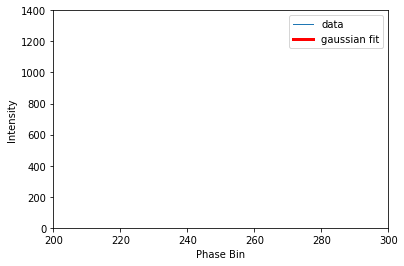

In [34]:
plot_fill(x,y,params)
py.axis([200,300,0,1400])
#py.axis([400,600,0,0.600])
#py.axis([60,120,0,0.9])
print(params)

pulse_component(frequency=1604.326923076923, comp1=component(phase=245.4036828132612, intensity=2.543361707098394), comp2=component(phase=258.6851299591972, intensity=1.829631967237959), errors=array([0.19628075, 0.31738509]))


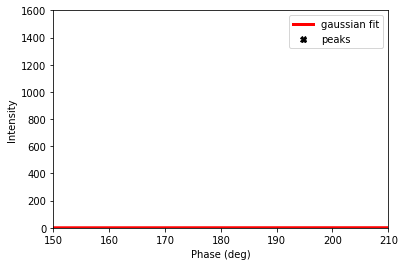

In [35]:
plot_peaks(x*(360/len(x)),y,profile_comp)
py.axis([150,210,0,1600])
print(profile_comp)

# ALL FREQUENCY BANDS

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### Parkes Data

In [36]:
fit_components = []
#Taken from Peaks and Gaussian fittings of frequency band 6, in the middle
#expected=(0.1,660,6,0.75,695,20,0.2,720,10,0.25,750,15)
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,625,0,0,675,0,0,712,0,0,720,0],[np.inf,675,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,760,np.inf])


#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, minf,maxf,error)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        fit_components.append(profile_comp)

/home/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-8-872f30e54463>:32: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


peaks 1 [695.8283995676154] band 10
peaks 2 [695.072725654964, 716.9365814255478] band 11
peaks 1 [697.1616452289884] band 12
peaks 3 [662.639662154306, 698.8087471865158, 713.0789286450611] band 15
peaks 3 [661.8229147501381, 703.8016096329081, 711.9224745318555] band 16
peaks 3 [625.1974122552083, 697.3895080568758, 713.8808155389441] band 17
peaks 1 [694.5816063572396] band 40
peaks 1 [695.0645676111252] band 41
peaks 1 [695.4490561727138] band 46
peaks 1 [691.6390251153838] band 94
peaks 2 [663.4319174679658, 693.0578633928668] band 98
Too noisey 99
peaks 3 [688.3495477249797, 715.437071253965, 744.2759940454607] band 99
Too noisey 101
peaks 4 [664.714969784457, 693.9312206830281, 711.6823192829064, 745.5259944619842] band 101
Too noisey 102
peaks 4 [663.9988275586455, 690.657777296811, 714.2035369264452, 743.7912278149332] band 102
Too noisey 103
peaks 3 [661.5881865582438, 694.7173464204102, 749.0287594153663] band 103


#### EPN Data

In [37]:
ant_components = []
expected1=(1,85,3,0.6,90,3)
bounds1=([0,0,0,0,88,0],[np.inf,ant_phase,np.inf,np.inf,ant_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,len(ant_freq)):
    freqband = i
    f = ant['frequency'] == freqband
    x=ant['phase'][f]
    y=ant['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,ant_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        ant_components.append(profile_comp)

[86.35760633 91.02295404]
[0.92552287 0.40126563]
[86.23853255 91.45039212]
[0.98331631 0.54380821]
[86.22038573 91.75556784]
[1.00296912 0.633054  ]
[85.95008795 91.7502448 ]
[0.97003564 0.5848141 ]


In [38]:
gl_components = []
expected1=(200,210,3,1500,220,5,600,240,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,2):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.77161072 223.84233694 237.68815482]
[1525.2518016  1553.24928419  625.30054279]
0
[214.77115133 230.97477944 248.14453084]
[123.85137889 620.32396069 321.32508712]
0


In [39]:
expected1=(100,230,3,1000,240,5,500,260,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(2,4):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.50226148 239.03998507 257.861662  ]
[ 249.90583203 1157.80826511  715.4809543 ]
0
[227.15616563 243.30267316 263.03545319]
[134.39982169 357.00125166 238.20775962]
0


# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

<ErrorbarContainer object of 3 artists>

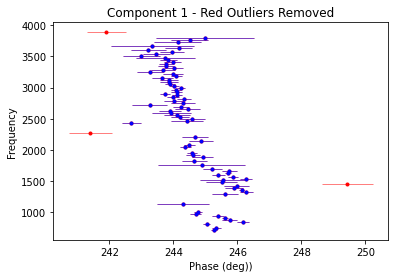

In [40]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)
#Plot points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 1 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,2)
#Plot outlier removed points"
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='blue',label='data')

In [41]:
#Fit the thorsett model to the component position
y_range=list(range(700,4040))

#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(y_range, *comp1_paramspl)
comp1_fitpl2 = powerlaw(frequency_comp1, *comp1_paramspl)

#Fit a linear 
comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
comp1_fitlin = linear(y_range, *comp1_paramslin)
comp1_fitlin2 = linear(frequency_comp1, *comp1_paramslin)

#Residuals
comp1_resid_lin = phase_comp1 - comp1_fitlin2

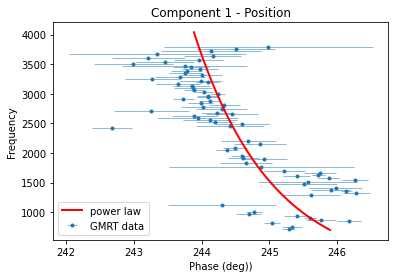

In [42]:
#Graph points with the fit ontop
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp1_fitpl, y_range,color='red',lw=2, label='power law', zorder=1)
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower left')

In [43]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramslin[0]:.6f} \u03BD +{comp1_paramslin[1]:.3f}')
print(f'The errors are {comp1_fit_errorlin[0]}, {comp1_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 253.536 ν^-0.005
The errors are 0.9882054591958581, 0.0005233727685618021
The power law equation of fit for this pulse is: 	 Phase = -0.000714 ν +246.260
The errors are 6.460643363643336e-05, 0.13811036244268945


In [44]:
print('The chi squared reduced value is', chsq_err(phase_comp1, comp1_fitpl2, comp1_err)/(len(phase_comp1)-2))

The chi squared reduced value is 8.478142376252011


### Component 2

<ErrorbarContainer object of 3 artists>

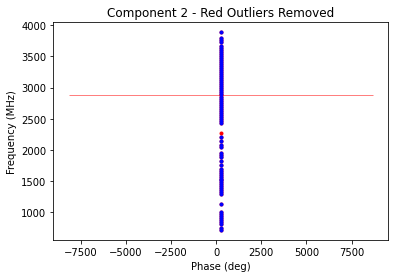

In [45]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)
#Plot points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 2 - Red Outliers Removed')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')

#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,2)
#Plot outlier removed points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='blue',label='data')

In [46]:
#Temporary for viewing
#print(comp2_err)
#ind=comp2_err.index(0)
#del comp2_err[ind]
#del phase_comp2[ind]
#del frequency_comp2[ind]

In [47]:
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(y_range, *comp2_paramspl)
comp2_fitpl2 = powerlaw(frequency_comp2, *comp2_paramspl)

#Fit a linear 
comp2_paramslin,comp2_covlin=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorlin=np.sqrt(np.diag(comp2_covlin))
comp2_fitlin = linear(y_range, *comp2_paramslin)
comp2_fitlin2 = linear(frequency_comp2, *comp2_paramslin)

#Residuals
comp2_resid_lin = phase_comp2 - comp2_fitlin2

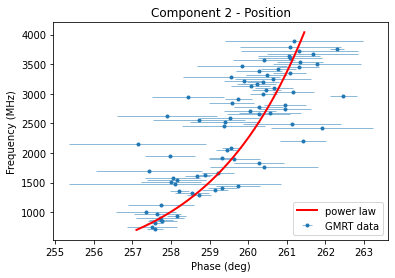

In [48]:
#Graph points with the fit ontop
py.errorbar( phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 2 - Position')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend(loc='lower right')

In [49]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramslin[0]:.5f} \u03BD +{comp2_paramslin[1]:.3f}')
print(f'The errors are {comp2_fit_errorlin[0]}, {comp2_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 241.486 ν^0.010
The errors are 0.9642897959444807, 0.0005309836442548293
The power law equation of fit for this pulse is: 	 Phase = 0.00134 ν +256.682
The errors are 6.624979896195624e-05, 0.1518111719301262


In [50]:
print('The chi squared reduced value is',chsq_err(phase_comp2, comp2_fitpl2, comp2_err)/(len(phase_comp2)-2))

The chi squared reduced value is 2.1113787680300224


# Both Component Movements

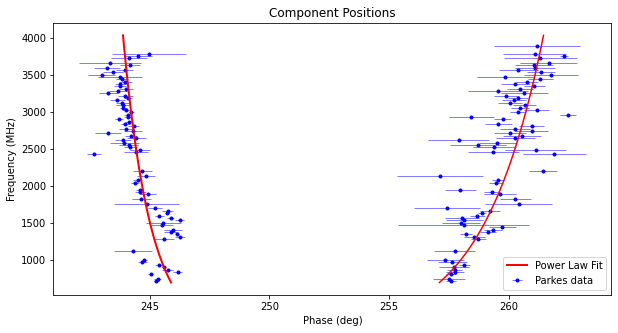

In [51]:
py.figure(figsize=(10,5))
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Parkes data', zorder=0)
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='blue', fmt='.', lw=0.5, zorder=0)
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='Power Law Fit', zorder=1)
py.plot(comp2_fitpl,y_range, color='red', zorder=1)
py.title('Component Positions')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend()

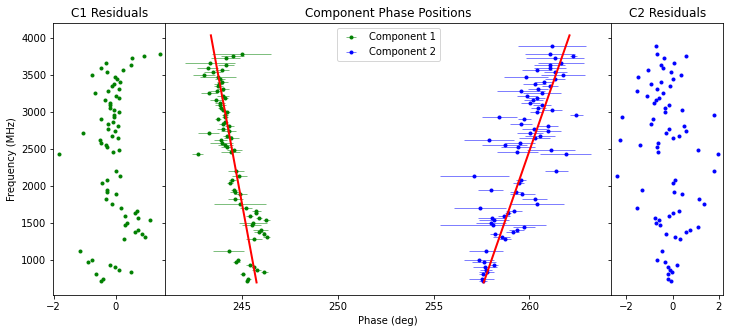

In [52]:
fig = py.figure(figsize=(12, 5))
grid = py.GridSpec(1, 6, hspace=0, wspace=0)
resid_1 = fig.add_subplot(grid[0, 0])
py.ylabel('Frequency (MHz)')
main_ax = fig.add_subplot(grid[0, 1:5], sharey=resid_1)
py.xlabel('Phase (deg)')
resid_2 = fig.add_subplot(grid[0, 5], sharey=resid_1)

resid_1.plot(comp1_resid_lin, frequency_comp1, '.', color='g')
main_ax.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='green', fmt='.', lw=0.5, label='Component 1', zorder=0)
main_ax.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Component 2', zorder=0)
main_ax.plot(comp1_fitlin,y_range, color='red',lw=2, zorder=1)
main_ax.plot(comp2_fitlin,y_range, color='red',lw=2, zorder=1)
resid_2.plot(comp2_resid_lin, frequency_comp2, '.', color='b')

resid_1.set_title('C1 Residuals')
resid_2.set_title('C2 Residuals')
main_ax.set_title('Component Phase Positions')

main_ax.legend(loc='upper center')
resid_1.label_outer()
main_ax.label_outer()
resid_2.label_outer()


# Fitting Power Laws to Separation 

## Just Parkes

In [53]:
#Gain component separation values
component_sep, sep_error = separation_singleprofile(fit_components)

comp_sep=[]
frequency_forsep=[]

#Put them into arrays for graphing
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0.5, 1.0, 'Component Separation - Red Outliers Removed')

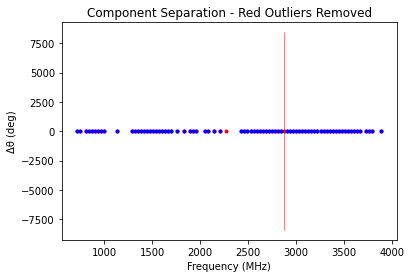

In [54]:
#Plot points
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5, label='data')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')

#Remove outliers
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

#Plot points with outliers removed
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='blue', fmt='.', lw=0.5, label='data')
py.title('Component Separation - Red Outliers Removed')

In [55]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

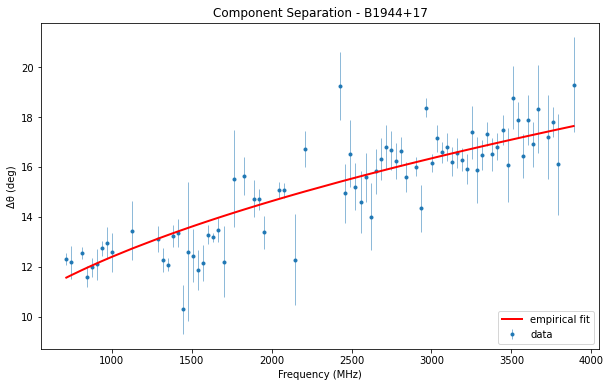

In [56]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='empirical fit',zorder=2)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')


In [57]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')
print('The chi squared reduced value is',chsq_err(comp_sep, separation_fit, sep_error)/(len(comp_sep)-2))

The equation of fit for this pulsar is: 	 Δθ = 0.170 ν^0.500 + 7.005 

The errors are 0.385, 0.238, 3.344 
Units for Δθ is degrees and ν is MHz
The chi squared reduced value is 2.3214805793857405


## Parkes and EPN

In [58]:
#Gain component separation values
ant_sep, ant_error = separation_singleprofile(ant_components)
gl_sep, gl_error = separation_singleprofile(gl_components)
j_sep, j_error = separation_singleprofile(j_components)
wc_sep, wc_error = separation_singleprofile(wc_components)
sgg_sep, sgg_error = separation_singleprofile(sgg_components)

epn_sep = [ant_sep, gl_sep, j_sep, wc_sep, sgg_sep]
epn_error = [ant_error, gl_error, j_error, wc_error, sgg_error]

epn_seps=[]
frequency_epn=[]
epn_errors=[]

#Put them into arrays for graphing
for k,epn in enumerate(epn_sep):
    for i in range(0,len(epn)):
        comp_sep.append(epn[i][1])
        frequency_forsep.append(epn[i][0])
        sep_error.append(epn_error[k][i])

        epn_seps.append(epn[i][1])
        frequency_epn.append(epn[i][0])
        epn_errors.append(epn_error[k][i])

In [59]:
epn_sep

[[component_separation(frequency=400, separation=13.121290455683464),
  component_separation(frequency=800, separation=14.65835504125883),
  component_separation(frequency=1330, separation=15.567699695482787),
  component_separation(frequency=1640, separation=16.31294112478261)],
 [component_separation(frequency=410, separation=11.10132391690243),
  component_separation(frequency=610, separation=12.823880712970833),
  component_separation(frequency=925, separation=13.771958731232957),
  component_separation(frequency=1408, separation=14.73817595847595)],
 [component_separation(frequency=673.9, separation=13.617310219134481)],
 [component_separation(frequency=1418, separation=11.431643163462525)],
 [component_separation(frequency=1420, separation=12.120002525867932),
  component_separation(frequency=4750, separation=20.304352220871735)]]

In [60]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

freq_fit = np.linspace(300, 4900, 460)
separation_fit=thorsett(freq_fit,*sep_params)

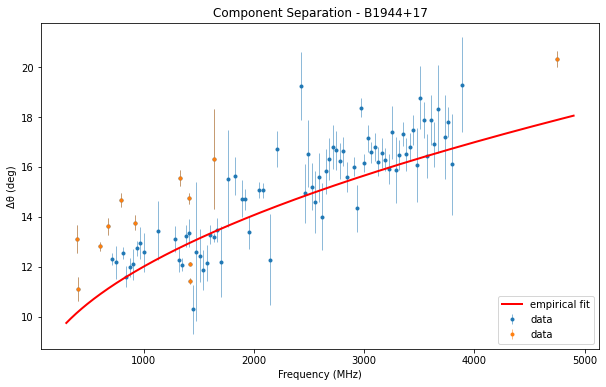

In [61]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.errorbar(frequency_epn, epn_seps, yerr=epn_errors, fmt='.', lw=0.5, label='data',zorder=2)
py.plot(freq_fit,separation_fit, color='red',lw=2,label='empirical fit',zorder=3)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')

# Change in Intensity over Frequency for GMRT

## Fit Peaks (fit_components)

Text(0, 0.5, 'Intensity')

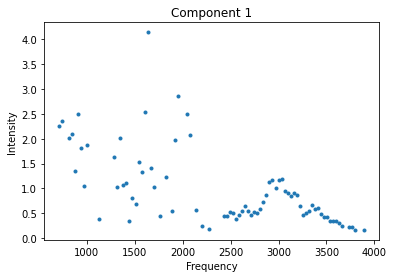

In [62]:
#Find intensity of components at each frequency and graph
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])
    
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1')
py.xlabel('Frequency')
py.ylabel('Intensity')

Text(0, 0.5, 'Intensity')

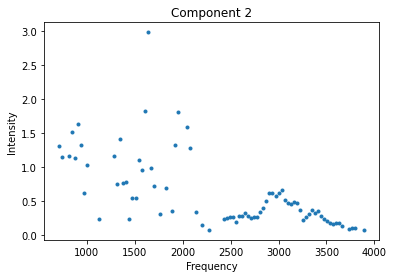

In [63]:
#Find intensity of components at each frequency and graph
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity')